In [23]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random

In [24]:
import zipfile
import os

zip_path = 'animal_dataset.zip'

if os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('.')
    print("Unzipping complete")
else:
    print("Error: upload 'animal_dataset.zip'.")

Unzipping complete


In [25]:
dataset_path = '/content/animal_dataset'
X, y, classes = load_dataset(dataset_path)

Classes set to: ['dog', 'panda', 'cat']
Loaded 100 images for class 'dog'
Loaded 100 images for class 'panda'
Loaded 100 images for class 'cat'
Total images loaded: 300


In [26]:
#RGB to Grayscale
def to_grayscale(img):
    if len(img.shape) == 2:
        return img
    return np.dot(img[..., :3], [0.299, 0.587, 0.114])
def resize_image(img, target_h=32, target_w=32):
    h, w = img.shape

    x_indices = np.linspace(0, w-1, target_w).astype(int)
    y_indices = np.linspace(0, h-1, target_h).astype(int)

    resized = img[np.ix_(y_indices, x_indices)]
    return resized

def calculate_distance(p1, p2, method='L2'):
    diff = p1 - p2
    if method == 'L1':
        return np.sum(np.abs(diff))
    else:
        return np.sqrt(np.sum(diff**2))

In [27]:
# Shuffle data randomly
indices = np.arange(len(X))
np.random.seed(42)
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

k_values = [1, 3, 5, 7, 9, 11, 13, 15]
num_folds = 5
fold_size = len(X) // num_folds

results = {
    'L1 (Manhattan)': [],
    'L2 (Euclidean)': []
}

print("Starting 5-Fold Cross-Validation")

#distance metrics
for metric in ['L1', 'L2']:
    print(f"\nEvaluating {metric} Distance...")
    metric_accuracies = []

    for k in k_values:
        fold_scores = []

        # 5-Fold
        for i in range(num_folds):
            start = i * fold_size
            end = start + fold_size

            X_val = X[start:end]
            y_val = y[start:end]

 # Training set
            X_train = np.concatenate((X[:start], X[end:]), axis=0)
            y_train = np.concatenate((y[:start], y[end:]), axis=0)

            correct_predictions = 0
            for j in range(len(X_val)):
                test_point = X_val[j]
                true_label = y_val[j]

                diff = X_train - test_point
                if metric == 'L1':
                    dists = np.sum(np.abs(diff), axis=1)
                else:
                    dists = np.sqrt(np.sum(diff**2, axis=1))

                nearest_indices = np.argpartition(dists, k)[:k]
                nearest_labels = y_train[nearest_indices]

                counts = np.bincount(nearest_labels)
                predicted_label = np.argmax(counts)

                if predicted_label == true_label:
                    correct_predictions += 1

            acc = correct_predictions / len(X_val)
            fold_scores.append(acc)

        avg_acc = np.mean(fold_scores)
        metric_accuracies.append(avg_acc)
        print(f"  K={k}: Accuracy={avg_acc:.4f}")

    results[f'{metric} ({"Manhattan" if metric=="L1" else "Euclidean"})'] = metric_accuracies

Starting 5-Fold Cross-Validation

Evaluating L1 Distance...
  K=1: Accuracy=0.3567
  K=3: Accuracy=0.3733
  K=5: Accuracy=0.3967
  K=7: Accuracy=0.4333
  K=9: Accuracy=0.4133
  K=11: Accuracy=0.4300
  K=13: Accuracy=0.4033
  K=15: Accuracy=0.4200

Evaluating L2 Distance...
  K=1: Accuracy=0.3700
  K=3: Accuracy=0.3500
  K=5: Accuracy=0.3700
  K=7: Accuracy=0.3733
  K=9: Accuracy=0.4000
  K=11: Accuracy=0.3933
  K=13: Accuracy=0.4000
  K=15: Accuracy=0.3700


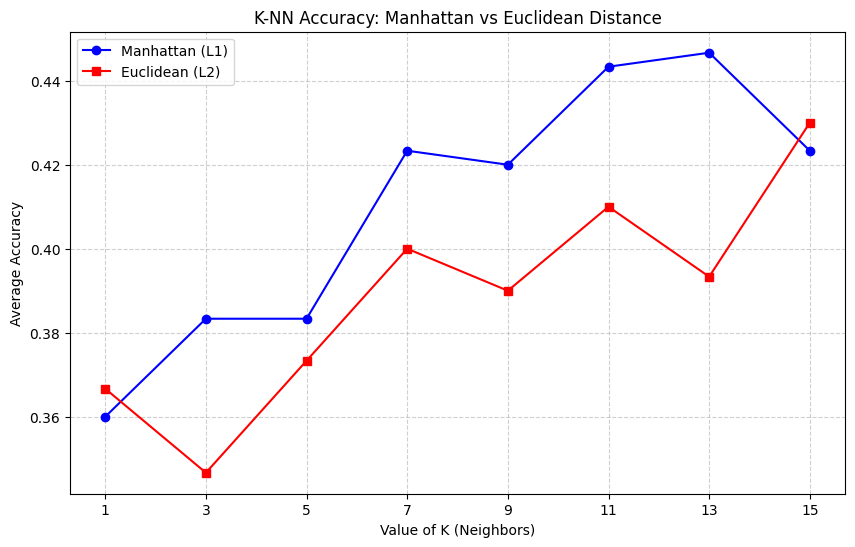


Discussion
Manhattan (L1) performed better with a max accuracy of 0.45.


In [17]:
plt.figure(figsize=(10, 6))

# Plot L1
plt.plot(k_values, results['L1 (Manhattan)'], marker='o', label='Manhattan (L1)', color='blue')

# Plot L2
plt.plot(k_values, results['L2 (Euclidean)'], marker='s', label='Euclidean (L2)', color='red')

plt.title('K-NN Accuracy: Manhattan vs Euclidean Distance')
plt.xlabel('Value of K (Neighbors)')
plt.ylabel('Average Accuracy')
plt.xticks(k_values)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Identify the best
best_l1 = max(results['L1 (Manhattan)'])
best_l2 = max(results['L2 (Euclidean)'])

print("\nDiscussion")
if best_l1 > best_l2:
    print(f"Manhattan (L1) performed better with a max accuracy of {best_l1:.2f}.")
elif best_l2 > best_l1:
    print(f"Euclidean (L2) performed better with a max accuracy of {best_l2:.2f}.")
else:
    print(f"Both metrics performed equally with a max accuracy of {best_l1:.2f}.")


Top 5 Predictions (Using K=5, L1)


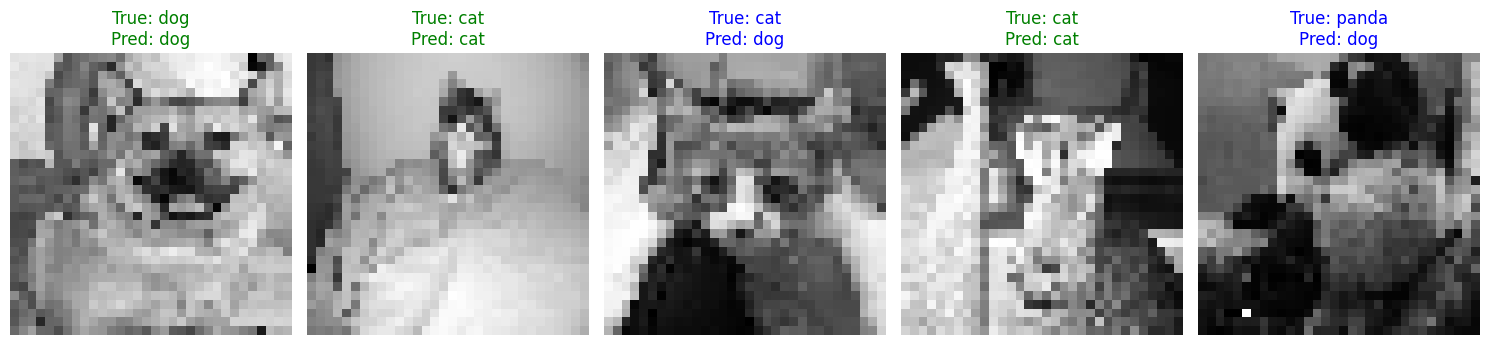

In [35]:
best_k =  5
best_metric = 'L1'
# Pick 5 random images from the dataset
random_indices = np.random.choice(len(X), 5 , replace=False)
X_demo = X[random_indices]
y_demo = y[random_indices]

X_train_full = X
y_train_full = y

print(f"\nTop 5 Predictions (Using K={best_k}, {best_metric})")

plt.figure(figsize=(15, 4))

for i in range(5):
    test_pt = X_demo[i]
    true_lbl = y_demo[i]
    diff = X_train_full - test_pt
    if best_metric == 'L1':
        dists = np.sum(np.abs(diff), axis=1)
    else:
        dists = np.sqrt(np.sum(diff**2, axis=1))
    nearest_idx = np.argpartition(dists, best_k)[:best_k]
    nearest_lbls = y_train_full[nearest_idx]

    counts = np.bincount(nearest_lbls)
    pred_lbl = np.argmax(counts)

    ax = plt.subplot(1, 5, i + 1)
    img_show = (test_pt * 255).reshape(32, 32)
    color = 'green' if pred_lbl == true_lbl else 'blue'

    plt.imshow(img_show, cmap='gray')
    plt.title(f"True: {classes[true_lbl]}\nPred: {classes[pred_lbl]}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()


Top 5 Predictions (Using K=5, L2)


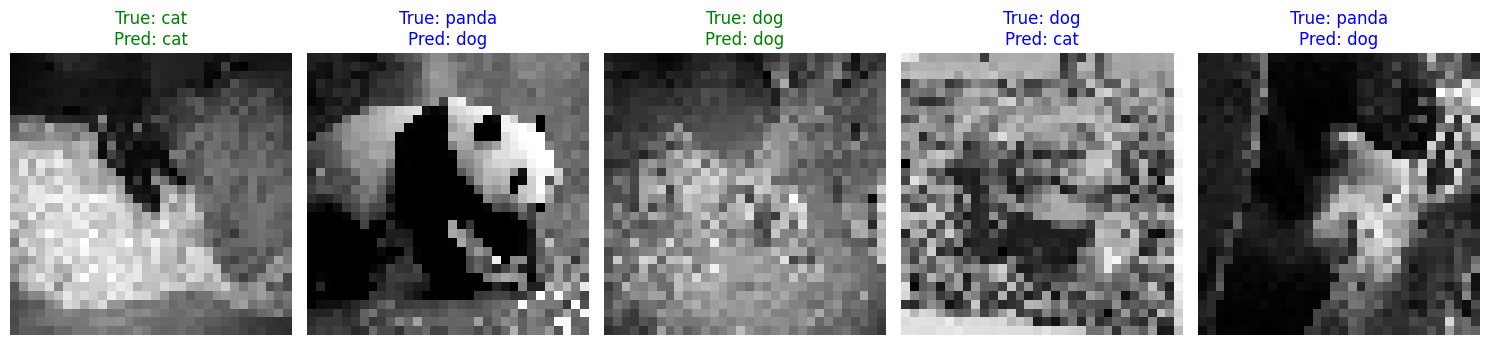

In [36]:
best_k =  5
best_metric = 'L2'

# Pick 5 random images from dataset
random_indices = np.random.choice(len(X), 5 , replace=False)
X_demo = X[random_indices]
y_demo = y[random_indices]

X_train_full = X
y_train_full = y

print(f"\nTop 5 Predictions (Using K={best_k}, {best_metric})")

plt.figure(figsize=(15, 4))

for i in range(5):
    test_pt = X_demo[i]
    true_lbl = y_demo[i]

    diff = X_train_full - test_pt
    if best_metric == 'L1':
        dists = np.sum(np.abs(diff), axis=1)
    else:
        dists = np.sqrt(np.sum(diff**2, axis=1))

    nearest_idx = np.argpartition(dists, best_k)[:best_k]
    nearest_lbls = y_train_full[nearest_idx]

    counts = np.bincount(nearest_lbls)
    pred_lbl = np.argmax(counts)

    ax = plt.subplot(1, 5 , i + 1)
    img_show = (test_pt * 255).reshape(32, 32)
    color = 'green' if pred_lbl == true_lbl else 'blue'

    plt.imshow(img_show, cmap='gray')
    plt.title(f"True: {classes[true_lbl]}\nPred: {classes[pred_lbl]}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()